# Structured output

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%reload_ext autoreload

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from openai import AzureOpenAI
from models.news import Nyhet, ClusterInfo
from pydantic import BaseModel
from llm.setup import create_azure_client

## Data

In [6]:
descriptions_file = "../data/descriptions_with_clusters.parquet"
descriptions_with_clusters = pd.read_parquet(descriptions_file).rename(columns={"Document": "description"}).reset_index()

descriptions_with_clusters["Representation"] = descriptions_with_clusters["Representation"].astype(str).str.strip("[]").str.replace("'", "").str.replace(", ", " ")
display(descriptions_with_clusters.head())

,id,description,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,cluster
0,0,Øker kraftig: Setter inn ekstra buss. Antall b...,3,"3_Samferdsel, politikk og samfunn",Samferdsel politikk og samfunn,"[Filtrert bort pga. innhold, – Vi er nødt til ...","Samferdsel, politikk og samfunn",0.366949,False,3
1,1,Filtrert bort pga. innhold,0,"0_Lokalsamfunn, identitet, livsstil, bygdeutvi...",Lokalsamfunn identitet livsstil bygdeutvikling,[Når vi 20 grader? – Mest sannsynlig. Først må...,"Lokalsamfunn, identitet, livsstil, bygdeutvikling",1.000000,True,0
2,2,Filtrert bort pga. innhold,4,4_Rettssaker og vitnemål,Rettssaker og vitnemål,"[Filtrert bort pga. innhold, Filtrert bort pga...",Rettssaker og vitnemål,0.553104,True,4
3,3,Filtrert bort pga. innhold,8,8_Eldreomsorg og legemiddelbruk,Eldreomsorg og legemiddelbruk,"[Filtrert bort pga. innhold, Filtrert bort pga...",Eldreomsorg og legemiddelbruk,1.000000,True,8
4,4,Bedret resultatet i krevende marked,2,"2_Konkurs, overskudd og næringsliv",Konkurs overskudd og næringsliv,"[Selges for 1,5 millioner: 40 sengeplasser og ...","Konkurs, overskudd og næringsliv",0.491429,False,2


## Structured output from LLM

In [96]:
client = create_azure_client(async_mode=False)

In [97]:
def get_structured_output(user_input: str, client: AzureOpenAI, response_model: BaseModel, system_prompt: str) -> BaseModel:
    structured_output = client.beta.chat.structured_completion = client.beta.chat.completions.parse(
            model='gpt-4o',
            temperature=0,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_input}
            ],
            response_format=response_model,
        )
    return structured_output.choices[0].message.parsed

In [101]:
#Test the structured output
system_prompt = "Gi meg et strukturert svar for den følgende teksten."
sample = descriptions_with_clusters.sample()
user_input = sample["description"].values[0]
print(user_input)

Politiet etterforsker tivoli – kommer til Kristiansand denne uka. Axels tivoli skal være i Tresse i Kristiansand torsdag til søndag denne uka, uten berg- og dalbanen som hadde problemer i Skien.


In [102]:
structured_test = get_structured_output(user_input=user_input,  system_prompt=system_prompt, client=client, response_model=Nyhet)

In [103]:
# Print the Nyhet element in a structured format
print("Tema:", [tema.value for tema in structured_test.tema])
print("Objekter:")
for obj in structured_test.objekt:
    print(f"  - Type: {obj.type}, Navn: {obj.navn}")
print("Sentiment:", structured_test.sentiment.value)
print("Alvorlighetsgrad:", structured_test.alvorlighetsgrad.value)
print("Målgruppe:", [målgruppe.value for målgruppe in structured_test.målgruppe])
print("Clickbait:")
print("  - Clickbait:", structured_test.clickbait.clickbait)
print("  - Clickbait Score:", structured_test.clickbait.clickbait_score)
print("  - Clickbait Text:", structured_test.clickbait.clickbait_text)

Tema: ['Samfunn', 'Underholdning']
Objekter:
  - Type: Organisasjon, Navn: Axels Tivoli
  - Type: Sted, Navn: Kristiansand
  - Type: Sted, Navn: Skien
Sentiment: Nøytralt
Alvorlighetsgrad: Moderat
Målgruppe: ['Voksne', 'Ungdom']
Clickbait:
  - Clickbait: True
  - Clickbait Score: 0.7
  - Clickbait Text: Politiet etterforsker tivoli – kommer til Kristiansand denne uka.


### Repeat for all documents

In [41]:
# Initialize a list to store the structured outputs for each cluster
cluster_models = []

# Get all unique clusters from the descriptions_with_clusters dataframe
unique_clusters = descriptions_with_clusters['cluster'].unique()

# Process each unique cluster
for cluster_id in unique_clusters:
    # Filter the dataframe for the current cluster
    cluster_data = descriptions_with_clusters[descriptions_with_clusters['cluster'] == cluster_id]
    
    # Extract cluster metadata
    cluster_name = cluster_data['Representation'].iloc[0]
    cluster_size = len(cluster_data)
    description_ids = cluster_data['id'].tolist()
    
    # Create the cluster_text by joining all descriptions in the cluster
    cluster_text = "\n".join(cluster_data['description'].tolist())
    
    # Generate structured output for the cluster using ClusterInfo
    system_prompt_cluster = "Gi meg et strukturert svar for denne gruppen av nyhetssaker."
    try:
        structured_completion_cluster = client.beta.chat.completions.parse(
            model='gpt-4o',
            temperature=0.1,
            messages=[
                {"role": "system", "content": system_prompt_cluster},
                {"role": "user", "content": cluster_text}
            ],
            response_format=ClusterInfo,  # Use ClusterInfo for the cluster
        )
        
        # Parse the structured output into a ClusterInfo model
        cluster_info = structured_completion_cluster.choices[0].message.parsed
        
        # Generate structured output for each document in the cluster using Nyhet
        document_outputs = []
        for _, row in cluster_data.iterrows():
            document_text = row['description']
            system_prompt_document = "Gi meg et strukturert svar for denne nyhetssaken."
            try:
                structured_completion_document = client.beta.chat.completions.parse(
                    model='gpt-4o',
                    temperature=0.1,
                    messages=[
                        {"role": "system", "content": system_prompt_document},
                        {"role": "user", "content": document_text}
                    ],
                    response_format=Nyhet,  # Use Nyhet for individual documents
                )
                
                # Parse the structured output into a Nyhet model
                document_output = structured_completion_document.choices[0].message.parsed
                document_outputs.append({
                    "document_text": document_text,
                    "structured_output": document_output.model_dump(mode="json")  # Convert Nyhet model to JSON
                })
            except Exception as e:
                print(f"Error processing document ID {row['id']}: {str(e)}")
        
        # Combine the structured output with cluster metadata
        combined_output = {
            "cluster_id": cluster_id,
            "cluster_name": cluster_name,
            "cluster_size": cluster_size,
            "description_ids": description_ids,
            "cluster_info": cluster_info.model_dump(mode="json"),  # Convert ClusterInfo model to JSON
            "documents": document_outputs  # Add all document-level structured outputs
        }

        # Append the combined output to the list
        cluster_models.append(combined_output)
        
        print(f"Processed cluster {cluster_id} ({cluster_name}) with {cluster_size} descriptions")
    except Exception as e:
        print(f"Error processing cluster {cluster_id} ({cluster_name}): {str(e)}")

# Print the total number of successfully processed clusters
print(f"\nTotal clusters processed: {len(cluster_models)}")

Processed cluster 2 (Trafikk transport og samfunn) with 12 descriptions
Processed cluster 13 (Sommerløpet utfordringer og redning) with 4 descriptions
Processed cluster 3 (Rettssaker og vitneforklaringer) with 12 descriptions
Processed cluster 11 (Reseptforskrivning og eldreomsorg) with 5 descriptions
Processed cluster 4 (Konkurs og økonomiske resultater) with 9 descriptions
Processed cluster 6 (Byutvikling og havneplaner Kristiansand) with 7 descriptions
Processed cluster -1 (Lokale nyheter og samfunn) with 17 descriptions
Processed cluster 7 (Boligprosjekter og næringslivsendringer) with 7 descriptions
Processed cluster 0 (Sosiale utfordringer og mestring) with 26 descriptions
Processed cluster 5 (Nye hjem og kulturopplevelser) with 8 descriptions
Processed cluster 9 (Energi bøter og priser) with 6 descriptions
Processed cluster 8 (Politiaksjoner og arrangementer Kristiansand) with 7 descriptions
Processed cluster 1 (Sørlandsfotball og sportsnyheter) with 18 descriptions
Processed cl

In [42]:
# Save the combined output to a JSON file
output_file = "../data/clusters_with_structured_output_both_doc_cluster.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(cluster_models, f, ensure_ascii=False, indent=4, default=str)

print(f"Saved structured output to {output_file}")

Saved structured output to ../data/clusters_with_structured_output_both_doc_cluster.json


# Analyse the results

In [64]:
# Load the JSON file into a Python object
with open("../data/clusters_with_structured_output_both_doc_cluster.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten the JSON structure into a DataFrame
rows = []
for cluster in data:
    cluster_id = cluster["cluster_id"]
    cluster_name = cluster["cluster_name"]
    cluster_size = cluster["cluster_size"]
    description_ids = cluster["description_ids"]
    documents = cluster["documents"]
    
    for document in documents:
        document_text = document["document_text"]
        so = document["structured_output"]
        
        # Expand the 'objekt' column
        for obj in so.get("objekt", []):
            rows.append({
                "cid": cluster_id,
                "cname": cluster_name,
                "csize": cluster_size,
                "desc_ids": description_ids,
                "doc_text": document_text,
                "so_tema": so.get("tema", []),
                "so_sentiment": so.get("sentiment", None),
                "so_alvvorlighet": so.get("alvorlighetsgrad", None),
                "so_målgruppe": so.get("målgruppe", []),
                "so_clickbait": so.get("clickbait", {}).get("clickbait", None),
                "so_cb_score": so.get("clickbait", {}).get("clickbait_score", None),
                "so_cb_text": so.get("clickbait", {}).get("clickbait_text", None),
                "so_obj_type": obj.get("type", None),
                "so_obj_name": obj.get("navn", None),
            })

# Create a DataFrame from the rows
df = pd.DataFrame(rows)

# Display the DataFrame
display(df.head(2))

,cid,cname,csize,desc_ids,doc_text,so_tema,so_sentiment,so_alvvorlighet,so_målgruppe,so_clickbait,so_cb_score,so_cb_text,so_obj_type,so_obj_name
0,2,Trafikk transport og samfunn,12,"[0, 25, 26, 64, 81, 109, 110, 121, 135, 139, 1...",Øker kraftig: Setter inn ekstra buss. Antall b...,"[Samfunn, Reise]",Positivt,Lav,"[Voksne, Eldre]",True,0.7,Øker kraftig: Setter inn ekstra buss,Sted,Mandal
1,2,Trafikk transport og samfunn,12,"[0, 25, 26, 64, 81, 109, 110, 121, 135, 139, 1...",Øker kraftig: Setter inn ekstra buss. Antall b...,"[Samfunn, Reise]",Positivt,Lav,"[Voksne, Eldre]",True,0.7,Øker kraftig: Setter inn ekstra buss,Sted,Kristiansand


## Analyze the data
These are just some simple examples of ways to use the structured outputs to analyze the data

Samfunn Reise Samfunn Reise Sa


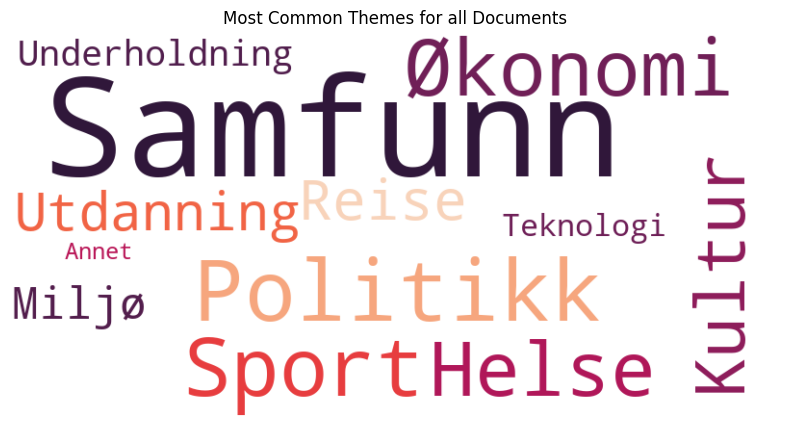

In [ ]:
#plot a wordcloud showing the most common themes for all documents, based on the structured output
# Combine all themes into a single string
all_themes = " ".join([str(theme) for themes in df["so_tema"] for theme in themes])
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False, colormap='rocket').generate(all_themes)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Themes for all Documents")
plt.show()

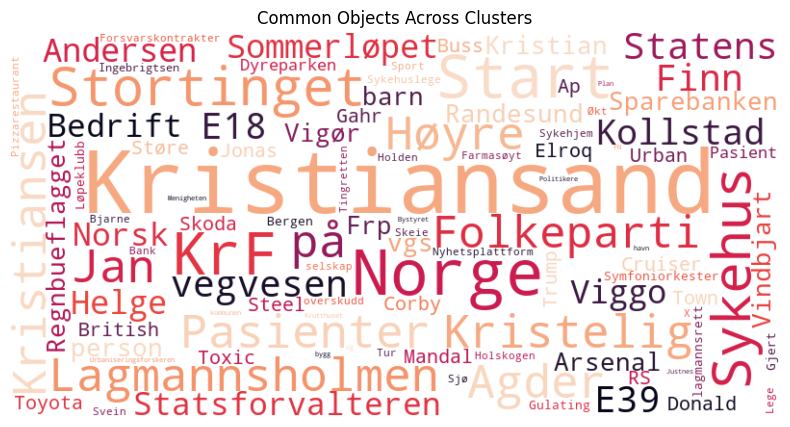

In [61]:
# Extract all 'so_obj_name' values from the DataFrame
all_objects = " ".join(df["so_obj_name"].astype(str)).replace("Innholdsmoderator","").replace("Ukjent","").replace("Filtreringssystem","")

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", collocations=False, colormap='rocket',max_words=100).generate(all_objects)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Objects Across Clusters")
plt.show()


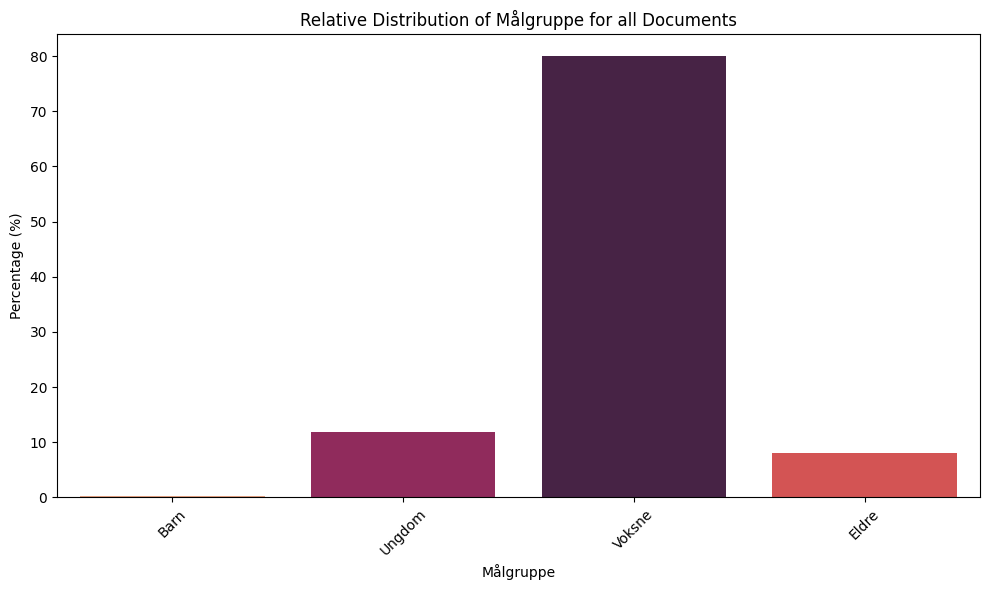

In [83]:
# Explode the 'so_målgruppe' column to handle multiple values per article
exploded_df = df.explode("so_målgruppe")

# Calculate the relative distribution of 'so_målgruppe'
target_counts = exploded_df["so_målgruppe"].value_counts(normalize=True) * 100

# Plot the relative distribution
plt.figure(figsize=(10, 6))
sns.barplot(
    x=target_counts.index,
    y=target_counts.values,
    palette="rocket",
    order=['Barn', 'Ungdom', 'Voksne', 'Eldre'],
    hue=target_counts.index
)
plt.xticks(rotation=45)
plt.xlabel("Målgruppe")
plt.ylabel("Percentage (%)")
plt.title("Relative Distribution of Målgruppe for all Documents")
plt.tight_layout()
plt.show()


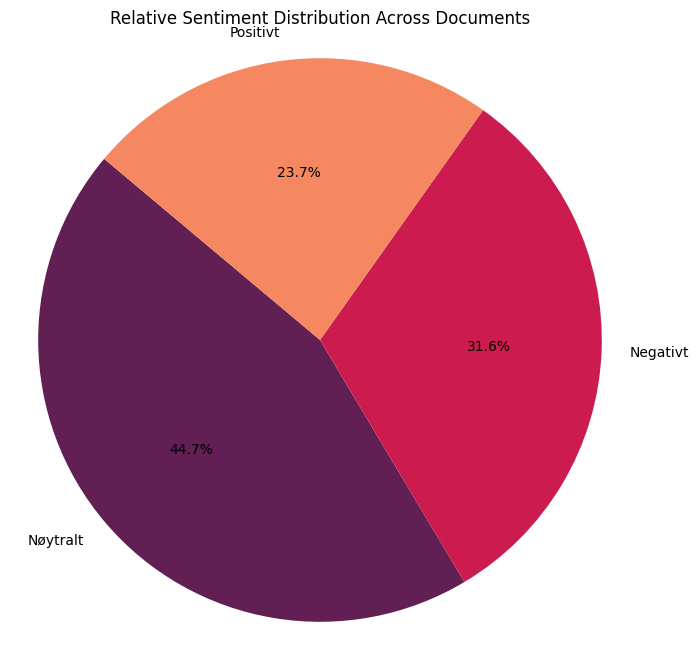

In [87]:
# Make pie chart of the relative sentiment distribution across documents
sentiment_counts = df["so_sentiment"].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette("rocket", n_colors=len(sentiment_counts))
)
plt.title("Relative Sentiment Distribution Across Documents")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


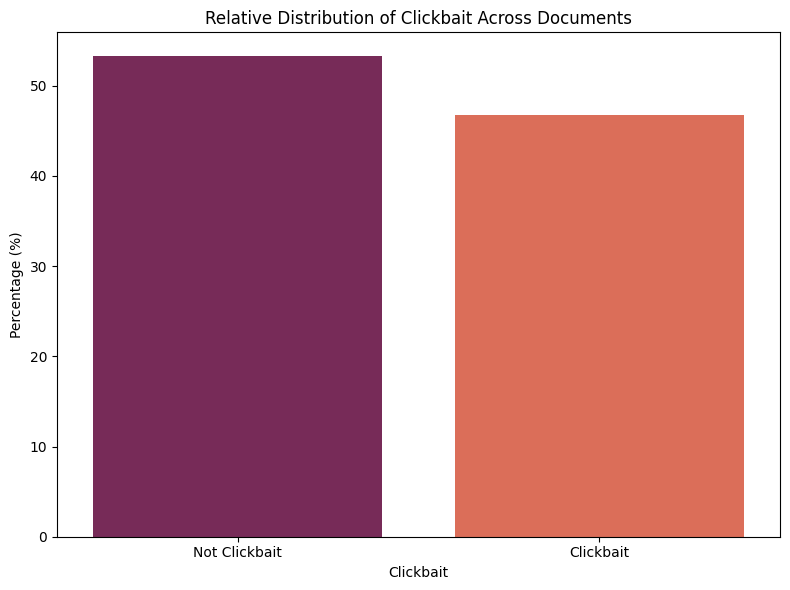

In [ ]:
# Calculate the relative distribution of clickbait
clickbait_distribution = df["so_clickbait"].value_counts(normalize=True) * 100

# Plot the relative distribution
plt.figure(figsize=(8, 6))
sns.barplot(
    x=clickbait_distribution.index,
    y=clickbait_distribution.values,
    palette="rocket",
    hue=clickbait_distribution.index
)
plt.xlabel("Clickbait")
plt.ylabel("Percentage (%)")
plt.title("Relative Distribution of Clickbait Across Documents")
plt.xticks([0, 1], ["Not Clickbait", "Clickbait"])
plt.legend().remove()
plt.tight_layout()
plt.show()

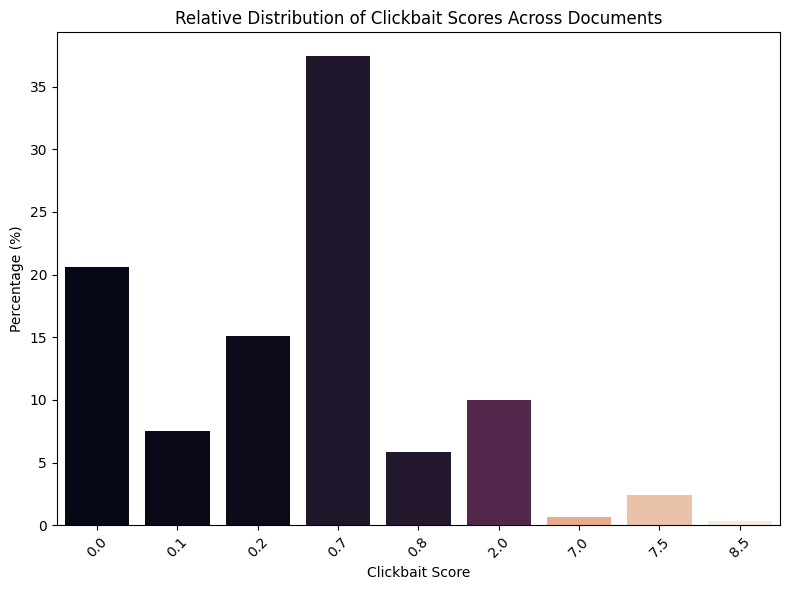

In [88]:
#show the relative distribution of clickbait scores across documents
clickbait_scores = df["so_cb_score"].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
sns.barplot(
    x=clickbait_scores.index,
    y=clickbait_scores.values,
    palette="rocket",
    hue=clickbait_scores.index
)
plt.xlabel("Clickbait Score")
plt.ylabel("Percentage (%)")
plt.title("Relative Distribution of Clickbait Scores Across Documents")
plt.xticks(rotation=45)
plt.legend().remove()
plt.tight_layout()
plt.show()

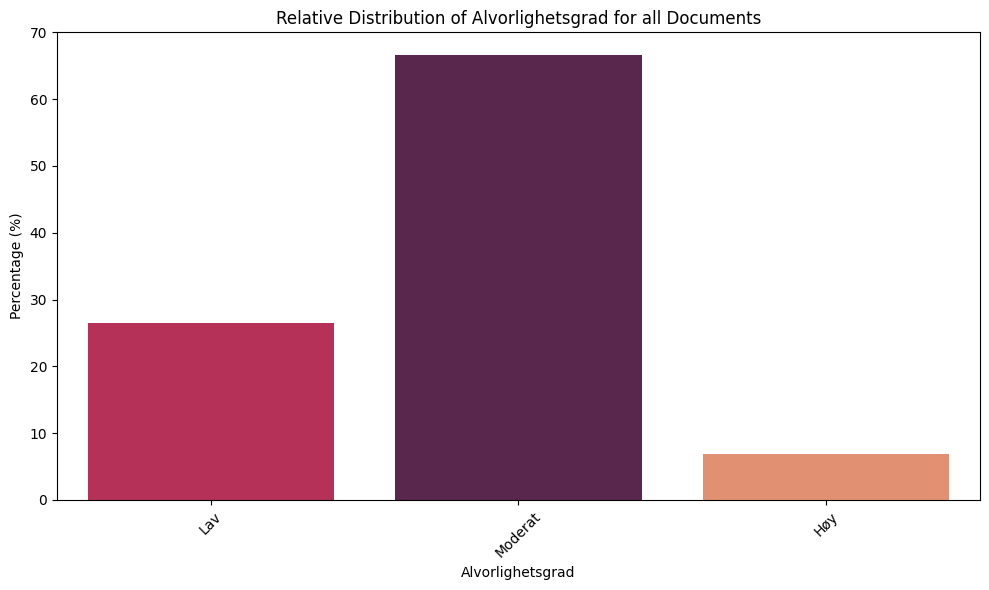

In [91]:
# relative distribution of 'so_alvorlighetsgrad'
alvorlighetsgrad_counts = df["so_alvvorlighet"].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x=alvorlighetsgrad_counts.index,
    y=alvorlighetsgrad_counts.values,
    palette="rocket",
    order=['Lav', 'Moderat', 'Høy'],
    hue=alvorlighetsgrad_counts.index
)
plt.xticks(rotation=45)
plt.xlabel("Alvorlighetsgrad")
plt.ylabel("Percentage (%)")
plt.title("Relative Distribution of Alvorlighetsgrad for all Documents")
plt.tight_layout()
plt.show()